### <center>**Movie Recommendation System**</center>



---




<b>Group Members:</b>


1.   Bommena Saiteja - 21MCA1111
2.   Akula Venkata Harsha Vardhan - 21MCA1071






<b>Importing Libraries:</b>

In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

<b>DataSet: Movielens</b>

https://grouplens.org/datasets/movielens/100k

In [ ]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [ ]:
df_movies = movies 
df_ratings = ratings 



---



#### **Exploratory Data Analysis(EDA)**

In [ ]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<b>Most popular genres of movie released

<BarContainer object of 19 artists>

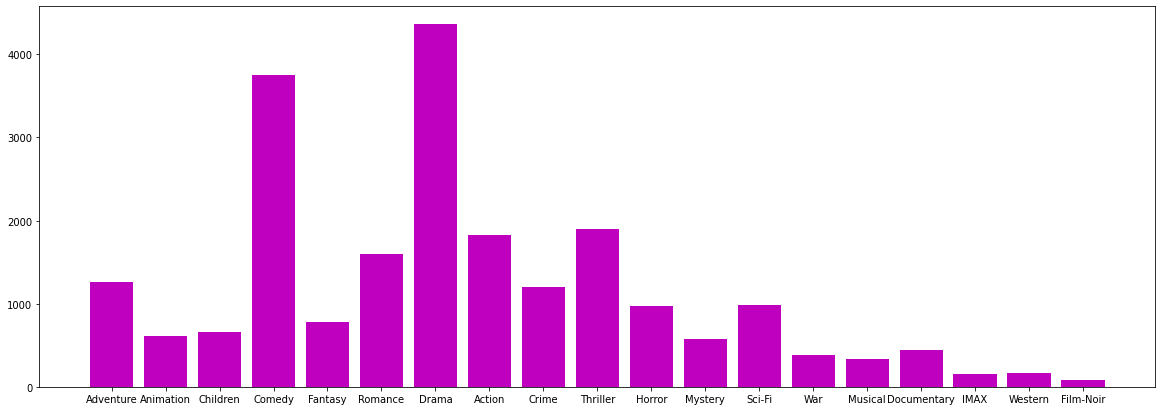

In [71]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m')

In [ ]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


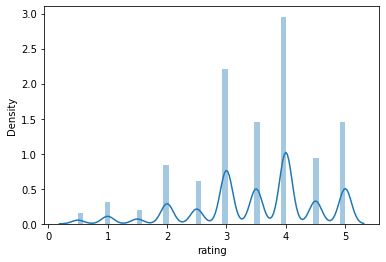

In [ ]:
sns.distplot(df_ratings["rating"]);

In [70]:
print(" Shape of frames: \n"+ " Rating DataFrame"+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movies.shape))

 Shape of frames: 
 Rating DataFrame(100836, 4)
 Movies DataFrame(9742, 3)


In [ ]:
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [ ]:
merge_ratings_movies.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962


In [ ]:
merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)

In [ ]:
merge_ratings_movies.shape

(100836, 5)

In [ ]:
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])

In [ ]:
ratings_grouped_by_users.head(2)

movieId               rating          
          size          mean   size      mean
userId                                       
1          232   1854.603448    232  4.366379
2           29  70350.275862     29  3.948276

In [ ]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

<b>Top 10 users who have rated most of the movies</b>

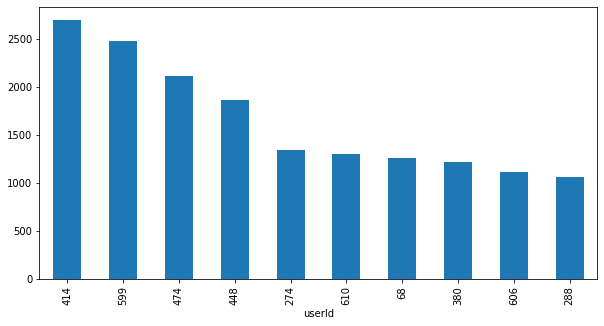

In [ ]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind='bar', figsize = (10,5))

In [ ]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.mean], np.size)

In [ ]:
ratings_grouped_by_movies.shape

(9724, 2)

In [ ]:
ratings_grouped_by_movies.head(3)

,userId,rating
,mean,mean
movieId,,
1,306.530233,3.920930
2,329.554545,3.431818
3,283.596154,3.259615


In [ ]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

<b>Movies with high average rating

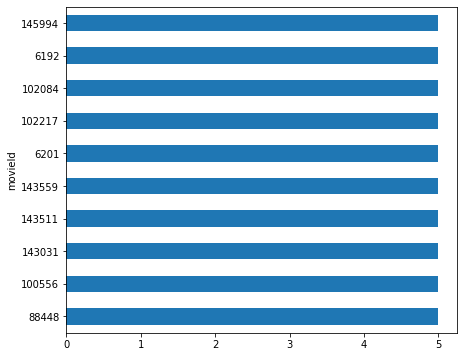

In [ ]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6));

<b>Movies with low average rating

In [ ]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [ ]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

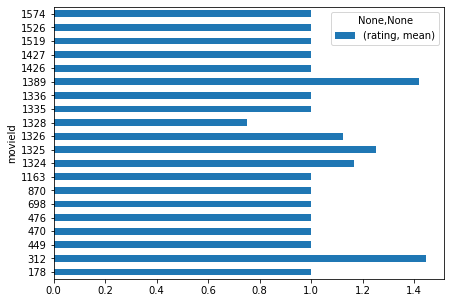

In [ ]:
low_rated_movies.head(20).plot(kind='barh', figsize=(7,5));

In [ ]:
low_rated_movies.head(10)

,rating
,mean
movieId,
178,1.000000
312,1.444444
449,1.000000
470,1.000000
476,1.000000
698,1.000000
870,1.000000
1163,1.000000




---



#### **Content Based Filtering**

In [ ]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])
# print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
# print(tfidf_movies_genres_matrix.shape)
# print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
# print(cosine_sim_movies)

In [ ]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:3]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return df_movies['title'].iloc[movie_indices]


In [ ]:
get_recommendations_based_on_genres("Adventures in Babysitting (1987)")

732     Around the World in 80 Days (1956)
1591      Adventures in Babysitting (1987)
Name: title, dtype: object

In [ ]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"]==df_movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)

# output of content_model     
get_recommendation_content_model(1)

{'101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 '39 Steps, The (1935)',
 'Ace Ventura: When Nature Calls (1995)',
 'Adventures in Babysitting (1987)',
 'Adventures of Robin Hood, The (1938)',
 'Alamo, The (1960)',
 'Alien Nation (1988)',
 'Amateur (1994)',
 'Amazing Panda Adventure, The (1995)',
 "Antonia's Line (Antonia) (1995)",
 'Antz (1998)',
 'Aristocats, The (1970)',
 'Around the World in 80 Days (1956)',
 'Assassins (1995)',
 'Austin Powers: The Spy Who Shagged Me (1999)',
 'BURN-E (2008)',
 'Babes in Toyland (1934)',
 'Backbeat (1993)',
 'Barb Wire (1996)',
 'Batman: Mystery of the Batwoman (2003)',
 'Beat the Devil (1953)',
 'Before the Rain (Pred dozhdot) (1994)',
 'Ben-Hur (1959)',
 'Big Bully (1996)',
 'Big Country, The (1958)',
 'Big Trouble in Little China (1986)',
 'Black Hole, The (1979)',
 'Blazing Saddles (1974)',
 'Blues Brothers 2000 (1998)',
 'Boot, Das (Boat, The) (1981)',
 'Bride of Frankenstein, The (Bride of Frankenstein) (1935)',
 'Broken Arrow (19



---



#### **Collabarative Filitering**


*   <b>Implementation of Item-Item Filtering




In [ ]:
df_movies_ratings=pd.merge(df_movies, df_ratings)

In [ ]:
df_movies_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [ ]:
ratings_matrix_items = df_movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape

(9724, 610)

In [ ]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [ ]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.to_numpy(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items


,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
def item_similarity(movieName): 
    """
    recomendates similar movies
   :param data: name of the movie 
   """
    try:
        #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
        user_inp=movieName
        inp=df_movies[df_movies['title']==user_inp].index.tolist()
        inp=inp[0]

        df_movies['similarity'] = ratings_matrix_items.iloc[inp]
        df_movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

In [ ]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice=df_movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= df_ratings[df_ratings['userId']== user_id]['movieId']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= df_ratings[(df_ratings.movieId==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movieId']

In [ ]:
def movieIdToTitle(listMovieIDs):
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movie_id']==id]['title'])
    return movie_titles

In [ ]:
user_id=100
print("Recommended movies,:\n",movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id)))

Recommended movies,:
 [5    Heat (1995)
Name: title, dtype: object, 5    Heat (1995)
Name: title, dtype: object, 486    True Romance (1993)
Name: title, dtype: object, 486    True Romance (1993)
Name: title, dtype: object, 486    True Romance (1993)
Name: title, dtype: object, 486    True Romance (1993)
Name: title, dtype: object, 486    True Romance (1993)
Name: title, dtype: object, 5    Heat (1995)
Name: title, dtype: object, 486    True Romance (1993)
Name: title, dtype: object]
